## YEAST GROWTH KINETICS SCREEN

by Anastasia Abashidze


Blavatnik Center for Drug Discovery
***

## Introduction


#### Yeast Growth Kinetics: Growth Score approach

<div align="justify"> This pipeline was inspired by article of Cuevas and Edwards (2018), originally written for bacterial growth in 96-well plates. They introduce Growth Score (GS) metric which ultimately represent essential growth curve properties and used to reduce complex time-series data to a single numeric evaluation. The GS is defined by three parameters of the Zwietering (Zwietering et al., 1990) bacterial growth curve - the starting absorbance y0, biomass yield  A, and the maximum growth rate μ:
</div>  
<div align="justify">  
    
                                     GS = (A − y0) + 0.25μ  
</div> 
<div align="justify"> 
    
    
In yeast and bacteria, a higher rate of growth does not solely demonstrate fitness, which evidenced by the abundance of slow-growing bacteria throughout the environment. Nor is it a strong feature to ultimately predict larger bacterial densities. For example, two bacteria with the same phenotype can reach the same density, even if one grows at half the rate of the other. Essentially, the ability to reach that potential at a faster rate indicates some biological advantage but has less significance than yield. In GS maximum growth rate is included at an amount of 25% in order for biomass accumulation to result in the primary component of growth. Faster growth rates can occur within a short time frame, resulting in low yield and high rate and, therefore, causing a disproportionate GS if the magnitude of the growth rate was not reduced.
    
    

The GS provides distinct advantages over other metrics used to describe growth: First, it only uses growth curve properties (yield and growth rate) and not influenced by the length of the experiment. Second, GS can be used with results from other software that also performs growth curve modeling or parameterization (DuctApe (Galardini et al., 2014), GCAT (Bukhman et al., 2015), grofit (Kahm et al., 2010; Vaas et al., 2012), OmniLog Biolog Phenotype MicroArrays (Borglin et al., 2012; Vaas et al., 2012) without the need for the raw data. Finally, the time independence of Growth Score is also a benefit over measurements like Area Under the Curve (AUC) employed by some software. AUC is subject to similar biases as growth level–longer experiments directly affect how lag time and growth rate mathematically influence the AUC calculation.
</div>

#### Assay data  
We growth yeast bearing mutation in some protein in 384-well plate for 24 hours and screen for compounds which able to overcome mutation-induced growth inhibition and restore growth rates. The negative control well contain mutant yeasts without compounds, and positive control wells contain yeasts with some known 'resque' compound.  

***

#### References

* Cuevas DA, Edwards RA. 2018. Growth Score: a single metric to define growth in 96-well phenotype assays. PeerJ 6:e4681 https://doi.org/10.7717/peerj.4681
***

## The Workflow

[Import Packages and create Output Folder](#import)   
[Load Data](#load_data)   
[Calculate Growth Score and add Layout](#gscore)  
[Filtering out aberrant Curves](#filtering)   
[Normalize Growth Scores and extract Hits](#norm)   
[Plot Results](#viso)
 - [Plot Growth Scores](#point)   
 
[Running QC](#qc) 
 - [Heatmap](#heatmap)
 - [Get Statistics](#stat)  
 ***

### Import Packages and create Output Folder
<a id="import"></a>

In [1]:
from nbdev.showdoc import *
import os
import sys
sys.path.append('..//')
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib as mpl
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', style = 'white', palette = 'dark')
import simplydrug.core as sd

#### Create folder to save the output

In [2]:
path = ('yeast_output') 
if not os.path.exists(path):
    os.mkdir(path)
    print('Output folder created')

Output folder created


#### Defining parameters

In [3]:
# path to data
data_path = 'hts_data//yeast_data//Readings//yeast_plate1.csv'

# path to layout
layout_path = 'hts_data//yeast_data//yeast_screen_layout.xlsx'

#path to chemical library
chem_path = 'hts_data//compounds//example_chemicals.csv'

# which compounds to import to the layout
chem_plate = 'ex_plate1'

# how to name the output files
name = 'yeast_plate1_run1'

# define threshold
threshold = -2

palette = {'Sample':'Navy','Negative':'Darkred','Positive':'Darkgreen', 'Hit': 'Orange', 'Invalid_sample':'Darkgray'}
hue_order = ['Sample', 'Negative', 'Positive', 'Hit', 'Invalid_sample']

### Load OD Data
<a id="load_data"></a>
__Our measurements are in OD (Optical Density Units).__

In [4]:
data = pd.read_csv(data_path).drop(columns = ['Plate'])
print(data.shape)
display(data.head())

(24, 385)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,P16,P17,P18,P19,P20,P21,P22,P23,P24,Time
0,0.10855,0.10741,0.10730,0.10612,0.10625,0.10600,0.10759,0.10906,0.10610,0.10700,...,0.11049,0.10751,0.10896,0.13626,0.10694,0.13892,0.11320,0.10992,0.10985,1
1,0.13305,0.15728,0.17759,0.15336,0.14680,0.14378,0.14981,0.15486,0.15753,0.15000,...,0.16763,0.16443,0.16498,0.19219,0.15368,0.17047,0.16912,0.21371,0.18754,10
2,0.13855,0.16287,0.19161,0.15639,0.14765,0.14552,0.15325,0.15458,0.16348,0.15258,...,0.17244,0.16849,0.16860,0.20006,0.15578,0.17372,0.17247,0.23855,0.20897,11
3,0.14546,0.17211,0.21362,0.16433,0.15266,0.15139,0.16204,0.16146,0.17712,0.16010,...,0.17621,0.17358,0.17350,0.21128,0.15999,0.18078,0.17814,0.27272,0.23684,12
4,0.15335,0.18414,0.24391,0.17346,0.15779,0.15647,0.16871,0.16872,0.19193,0.16657,...,0.18027,0.17857,0.18002,0.22548,0.16413,0.18631,0.18379,0.31707,0.28121,13


### Calculate Growth Score
<a id="gscore"></a>

#### Writing growth score function
* __Create time-series table__
* __Calculate growth rate__
* __Calculate growth score__

In [5]:
def calculate_growth_score(df): 
     # create time-series table
    df = df.astype(float).sort_values(['Time']) # sort by time
    times = df['Time'].values.astype(int)
    ts_data = pd.DataFrame()
    for name, data in df.drop(columns = ['Time']).iteritems():
        ts_data = ts_data.append(pd.DataFrame({'Well': name, 'Time': times, 'OD': data}))
    
    # calculate drowth score
    score_data = pd.DataFrame()
    for name, well in ts_data.groupby('Well'):
        well = well.copy()
        well['past'] = np.append(well['OD'].values[0], well['OD'].values[:-1])
        well['grate'] = (well['OD'] - well['past'])/well['past']
        well['gscore'] = (well['OD'].max() - well['OD'].values[0]) + well['grate'].max()*0.25        
        score_data = score_data.append(well)
        
    score_data = score_data.drop(columns = ['past']) 
    return score_data

#### Calculate growth score and add layout

In [7]:
gs_data = calculate_growth_score(data)
gs_data = sd.add_layout(gs_data, layout_path, chem_path = chem_path, chem_plate = chem_plate)
display(gs_data.head(3))

Added  Well
Added  Status
Added compounds:  ex_plate1 



,Well,Time,OD,grate,gscore,Status,Plate,Compound_id,lib_name,SMILES,Compound Name,SecName
0,A1,1,0.10855,0.000000,0.55131,Negative,NaN,NaN,NaN,NaN,NaN,NaN
1,A1,2,0.11042,0.017227,0.55131,Negative,NaN,NaN,NaN,NaN,NaN,NaN
2,A1,3,0.11391,0.031607,0.55131,Negative,NaN,NaN,NaN,NaN,NaN,NaN


#### Plot growth curves

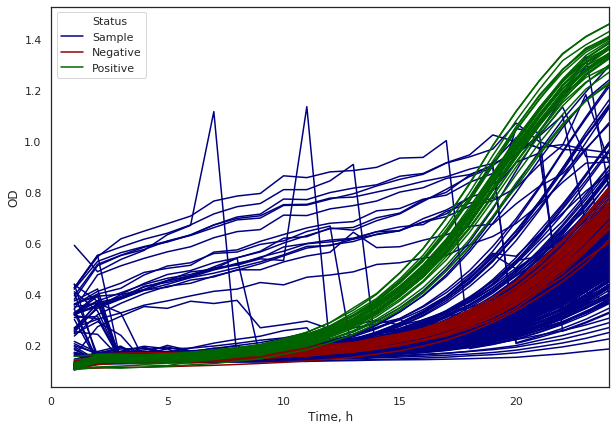

In [8]:
sd.plot_curve_raw(x = 'Time', y = 'OD', units = 'Well', hue = 'Status', hue_order = 
                   ['Sample', 'Negative', 'Positive'], df = gs_data, 
                       ylabel = 'OD', xlabel = 'Time, h', xlimit = 24, 
                              palette = palette, save_as = None, path = None)

### Filtering out aberrant curves
<a id="filtering"></a>

##### We will sign the curve as  'Invalid ' if there is big sudden drop (i.e, if well minimal growth rate < -0.1, or if growth curve starts  far away from plate start mean (i.e more than 20*start_std). You can adjust these criteria depending on your experiment. 
We will copy 'Status'column to new 'Result' column. If some curve meets filtering criteria, it's "result will be changed to ' Invalid curve'. In the future, if some compound will be choosen as hit, it's 'Result' will be changed to 'Hit'.

In [9]:
def filter_curves(df):
    clean = pd.DataFrame()
    for name, well in df.groupby('Well'):
        well = well.copy().sort_values(['Time'])
        
        # if there is big sudden drop 
        if (well['grate'].min() < -0.2) and (well['grate'].idxmin() > 4): #0.1
            print(name, well['grate'].min())
            well['Result'] = 'Invalid_sample'
        
        # if the curve started at high value
        elif well['OD'].values[0] >  0.2:
            print(name)
            well['Result'] = 'Invalid_sample'
        else:
            well['Result'] = well['Status']

        clean = clean.append(well)
    return clean
        

#### Plot validated curves

A14 -0.7773373223635003
B14 -0.2510783428628749
C10 -0.42940168081281094
C12 -0.7693703118392058
C14 -0.5430068547324017
C15 -0.20408460269719617
D10 -0.6657279697424408
D12 -0.7691103861752777
D13 -0.8135046310128473
D15 -0.6002221312912843
D9 -0.2083819072044766
E10 -0.22951896240354625
E12 -0.6342534336430082
E13 -0.7581915393230012
E14 -0.22641071739256505
E17 -0.29860113823732765
F12 -0.678866419823412
F17 -0.5526019224395096
F9 -0.6022544283413849
G11 -0.3848803480783176
G12 -0.5449987225344916
G13 -0.3949992513849379
G14 -0.2263380043896675
G9 -0.6477437355797607
H15 -0.4171749479321631
H16 -0.21731109232070106
H18 -0.594553084117276
I11 -0.8239254101781283
I12
I13
I14 -0.7230874266523969
I15 -0.6570330438254968
I16
J11 -0.5795950062720268
J12 -0.6487640943496968
J14 -0.5664883045405902
J7 -0.29337793720527183
K14 -0.5757954788126545
K15 -0.5974871454635926
L11 -0.8688461538461538
L12 -0.39630559098202156
L14 -0.7530531400966184
L17 -0.27448360908436964
M18
M4 -0.838895727096887

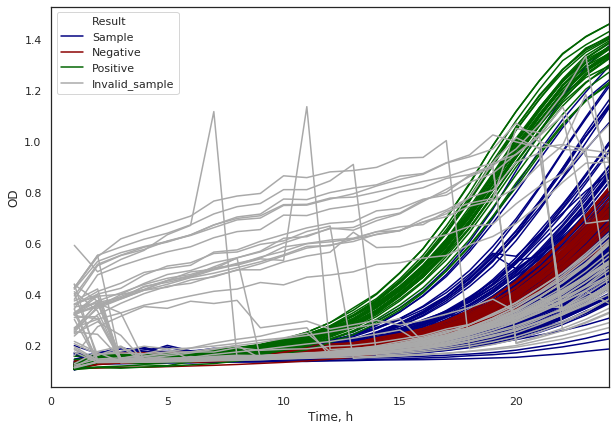

In [10]:
gs_data = filter_curves(gs_data)            
sd.plot_curve_raw(x = 'Time', y = 'OD', units = 'Well', hue = 'Result', 
                              hue_order = ['Sample', 'Negative', 'Positive', 'Invalid_sample'], 
                   df = gs_data, ylabel = 'OD', xlabel = 'Time, h', 
               xlimit = 24, palette = palette, save_as = None, path = None)

In [11]:
display(gs_data.head())

,Well,Time,OD,grate,gscore,Status,Plate,Compound_id,lib_name,SMILES,Compound Name,SecName,Result
0,A1,1,0.10855,0.000000,0.55131,Negative,NaN,NaN,NaN,NaN,NaN,NaN,Negative
1,A1,2,0.11042,0.017227,0.55131,Negative,NaN,NaN,NaN,NaN,NaN,NaN,Negative
2,A1,3,0.11391,0.031607,0.55131,Negative,NaN,NaN,NaN,NaN,NaN,NaN,Negative
3,A1,4,0.11382,-0.000790,0.55131,Negative,NaN,NaN,NaN,NaN,NaN,NaN,Negative
4,A1,5,0.11623,0.021174,0.55131,Negative,NaN,NaN,NaN,NaN,NaN,NaN,Negative


###  Normalize Growth Scores and extract Hits
<a id="norm"></a>

In [12]:
results = gs_data[['Plate', 'Well', 'Compound_id', 'gscore','Status', 'Result', 'SMILES', 
                                               'Compound Name', 'SecName']].drop_duplicates(subset = ['Well']) 

# normalize results
results = sd.normalize_z(results.copy(), 'gscore')

# select hits
results['Result'] = np.where((results['gscore_norm'] >= 2.5) & (results['Result'] =='Sample'), 'Hit', 
                             results['Result']) 

# update 'Result' in gs_data'
gs_data =  pd.merge(gs_data[['Well', 'Time', 'OD', 'grate', 'gscore', 
                             'Status', 'Plate', 'Compound_id']],results[['Well', 'Result']], how = 'left', on = 'Well')
print(results.shape)
display(results[150:153])

(384, 10)


,Plate,Well,Compound_id,gscore,Status,Result,SMILES,Compound Name,SecName,gscore_norm
3600,ex_plate1,G15,Compound_0132,0.509694,Sample,Sample,CC12CS(=O)(=O)CC1SC(=N)N2,NaN,NaN,-0.272159
3624,ex_plate1,G16,Compound_0133,0.520042,Sample,Sample,CSC1=CC(=O)CC(C)(C)S1,NaN,NaN,-0.219336
3648,ex_plate1,G17,Compound_0134,0.556208,Sample,Sample,CCc1nc2ccccc2nc1N1CCCC1,NaN,NaN,-0.034714


#### Plot final curves

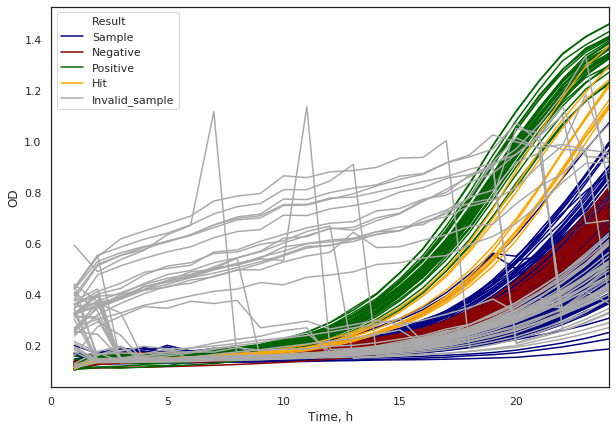

In [13]:
sd.plot_curve_raw(x = 'Time', y = 'OD', units = 'Well', hue = 'Result', hue_order = hue_order, 
                   df = gs_data, ylabel = 'OD', xlabel = 'Time, h', 
               xlimit = 24, palette = palette, save_as = 'all_curves.png', path = path)

#### Prepare separate plots for clean screen and invalid samples

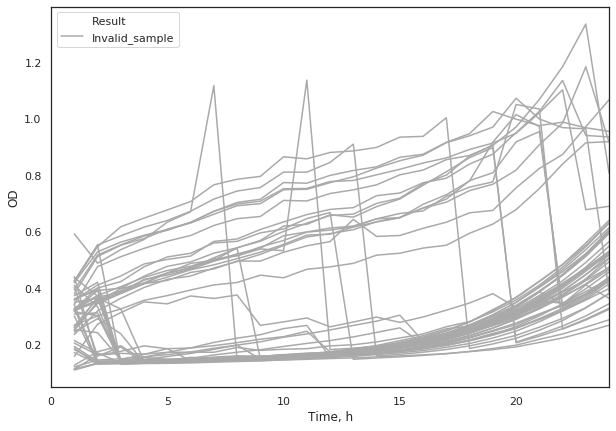

In [14]:
invalid = gs_data[gs_data['Result'] == 'Invalid_sample']
valid = gs_data[gs_data['Result'] != 'Invalid_curve']
sd.plot_curve_raw(x = 'Time', y = 'OD', units = 'Well', hue = 'Result', hue_order = ['Invalid_sample'], df = invalid, 
                       ylabel = 'OD', xlabel = 'Time, h', xlimit = 24, 
               palette = palette, save_as = 'invalid_curves.png', path = path)

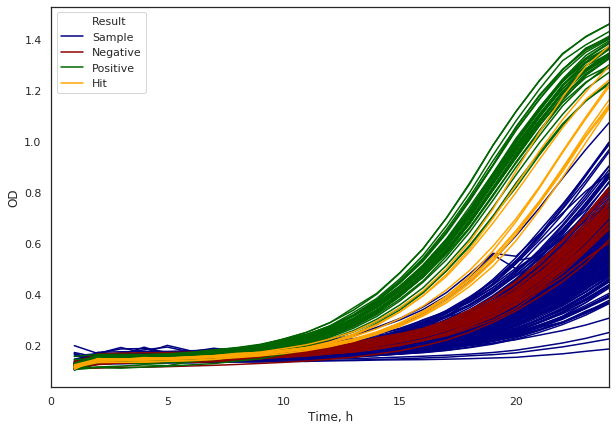

In [15]:
sd.plot_curve_raw(x = 'Time', y = 'OD', units = 'Well', hue = 'Result', 
                              hue_order = ['Sample', 'Negative', 'Positive', 'Hit'],
                              df = valid, ylabel = 'OD', xlabel = 'Time, h', 
               xlimit = 24, palette = palette, save_as = 'valid_curves.png', path = path)

#### Plot one compound (optionally)

In [16]:
# Select wells A11 and B12
wells = gs_data.copy().set_index('Well').filter(regex = 'A11$|B12$', axis = 0).reset_index()
plot_data = wells.append(valid[valid['Status'] == 'Positive']).append(valid[valid['Status'] == 'Negative'])

display(plot_data.head(3))

,Well,Time,OD,grate,gscore,Status,Plate,Compound_id,Result
0,A11,1,0.16261,0.000000,0.431527,Sample,ex_plate1,Compound_0009,Sample
1,A11,2,0.13200,-0.188242,0.431527,Sample,ex_plate1,Compound_0009,Sample
2,A11,3,0.13412,0.016061,0.431527,Sample,ex_plate1,Compound_0009,Sample


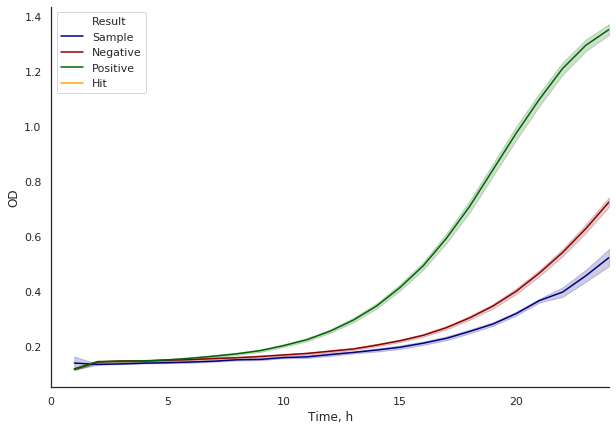

In [17]:
sd.plot_curve_mean(df = plot_data, x = 'Time', y = 'OD', hue = 'Result', 
                              hue_order = ['Sample', 'Negative', 'Positive', 'Hit'],
                        ylabel = 'OD', xlabel = 'Time, h', 
                               xlimit = 24, palette = palette, 
                save_as = 'A11_B12_curves.png', path = path)

In [18]:
my_compound = valid[valid['Compound_id'] == 'Compound_0014'].append(valid[valid['Status'] == 'Positive']).append(valid[valid['Status'] == 'Negative'])

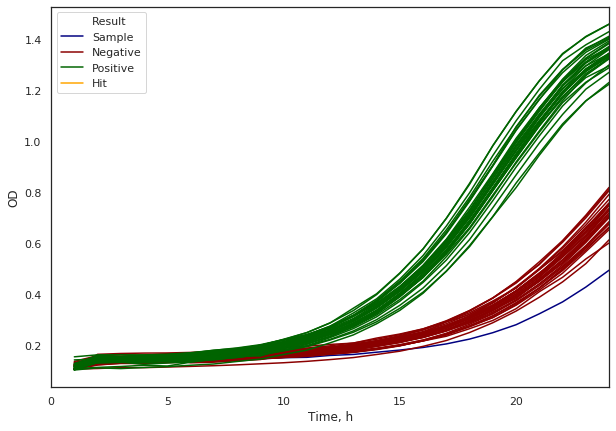

In [19]:
sd.plot_curve_raw(df = my_compound, x = 'Time', y = 'OD', units = 'Well', hue = 'Result', 
                              hue_order = ['Sample', 'Negative', 'Positive', 'Hit'],
                               ylabel = 'OD', xlabel = 'Time, h', 
                              xlimit = 24, palette = palette, 
                save_as = 'my_compound_curve.png', path = path)

### Plot Results
<a id="viso"></a>

#### Plot Growth Scores
<a id="pont"></a>

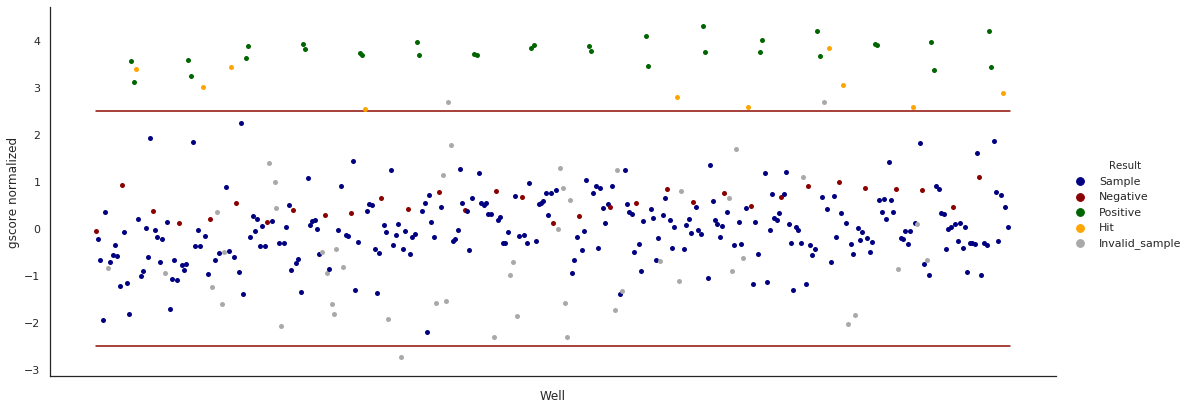

In [20]:
sd.pointplot_plate(df = results, x = 'Well', y = 'gscore_norm',  hue = 'Result',hue_order = hue_order,
                 threshold = 2.5, ylabel = 'gscore normalized', 
                palette = palette,  save_as = 'pointplot.png', path = path)

### Run QC
<a id="qc"></a>

#### Heatmap

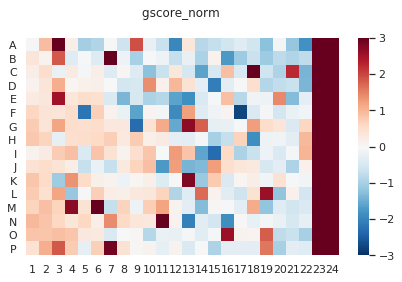

In [21]:
sd.hts_heatmap(df = results, layout_path = layout_path, features = ['gscore_norm'], save_as = 'heatmap.png', path = path)

#### Get Statistics
<a id="stat"></a>

,Feature,Status,size,mean,std,var,Z_factor,SB
0,gscore_norm,Negative,32.0,5.482908e-01,0.292473,0.085540,0.478343,6.889506
1,gscore_norm,Positive,32.0,3.777453e+00,0.269032,0.072378,0.478343,6.889506
2,gscore_norm,Sample,320.0,1.670972e-16,1.000000,1.000000,0.478343,6.889506


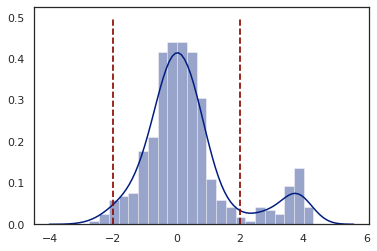

In [22]:
#calculate statistics
stats = sd.sum_statistics(results, 'gscore_norm')
stats.to_csv(path + '//sum_statistics.csv', index = False)
display(stats)
    
# histogram gscore-norm
sd.histogram_feature(df = results, feature = 'gscore_norm', save_as = 'histogram.png', path = path)

#### Save files to csv

In [23]:
results['Plate'] = name
results.to_csv(path + '//' + name + '_yeast_results.csv', index = False)
results[results['Result'] == 'Hit'].to_csv(path + '//' + name + '_yeast_hits.csv', index = False)
display(results.head())

,Plate,Well,Compound_id,gscore,Status,Result,SMILES,Compound Name,SecName,gscore_norm
0,yeast_plate1_run1,A1,NaN,0.551310,Negative,Negative,NaN,NaN,NaN,-0.059715
24,yeast_plate1_run1,A10,Compound_0008,0.519390,Sample,Sample,CCOC(=O)NC(C(=O)NC(C)c1ccccc1C)C(C)C,NaN,NaN,-0.222663
48,yeast_plate1_run1,A11,Compound_0009,0.431527,Sample,Sample,O=C(COC(=O)c1ccco1)NC1CC1,NaN,NaN,-0.671193
72,yeast_plate1_run1,A12,Compound_0010,0.180798,Sample,Sample,CCc1ccc(OCc2ccccc2C(=O)Nc2ccc3nc(C)cc(N)c3c2)cc1,JTC-801,NaN,-1.951126
96,yeast_plate1_run1,A13,Compound_0011,0.629706,Sample,Sample,CN(CC(=O)Nc1ccccc1C(=O)NCc1ccccc1)Cc1ccc(Cl)s1,NaN,NaN,0.340482


#### Create ppt and html reports and clean output folder


In [24]:
report = sd.create_presentation(path).save(path +'//' + name + '_yeast_kinetics_report.pptx')

In [25]:
# Save notebook as html for reporting
! jupyter nbconvert --to html 03a_yeast_growth_screen.ipynb

[NbConvertApp] Converting notebook 03a_yeast_growth_screen.ipynb to html
[NbConvertApp] Writing 1597264 bytes to 03a_yeast_growth_screen.html


In [26]:
# Clean output directory
for f in os.listdir(path):
    if '.png' in f:
        os.remove(path +'//' + f)
os.remove(path + '//sum_statistics.csv')
#os.remove(path + '//' + name + '_yeast_hits.csv')